# To make
- Databunch [x]
- learner
- fit one cycle
- show batch [x]

In [1]:
using Flux
using Flux.Data: DataLoader
using Flux.Optimise: Optimiser, WeightDecay
using Flux: onehotbatch, onecold, logitcrossentropy
using Statistics, Random
using Parameters: @with_kw
using Logging: with_logger, global_logger
import ProgressMeter
import MLDatasets
import DrWatson: savename, struct2dict
import BSON
using CUDAapi
using Plots
import GR
using Images
using CuArrays
gr()


Plots.GRBackend()

In [2]:
Threads.nthreads() = 8

In [3]:
path = "/media/subhaditya/DATA/COSMO/Datasets/signLangNumbers/Dataset/subset/0"
all_images = []
imageSize = 64
directory_files = readdir(path);
p = ProgressMeter.Progress(size(directory_files)[1])
for image_name in directory_files
    image_path = joinpath(path, image_name)
    image = Images.load(image_path);
    image = imresize(image, (imageSize,imageSize))
    push!(all_images, convert(Array{Float64}, channelview(image)))
    ProgressMeter.next!(p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


In [4]:
size(all_images[1])

(3, 64, 64)

## ShowBatch

In [5]:
function showBatch(arr,noImages)
    p = plot(axis = nothing,layout = noImages);

    for x in 1:noImages
        plot!(p[x],arr[x])
    
    end
    display(p)
end

showBatch (generic function with 1 method)

## Get all images

In [8]:
function listImages(directory_files,directory_path,imageSize,pb)
    directory_images = filter(x -> occursin(r"\.(jpg|png|gif|JPG){1}$"i, x), directory_files);

    all_images = []
    to_show = []
    temp_show = 0
    p = ProgressMeter.Progress(size(directory_images)[1])
#     @info length(directory_images)
    for image_name in directory_images
        image_path = joinpath(directory_path, image_name)
        image = Images.load(image_path);
        image = imresize(image, (imageSize,imageSize))
        if temp_show<=2
            push!(to_show,image)
            temp_show+=1
        end
        
        push!(all_images,  convert(Array{Float64}, channelview(image)))
        if pb
            ProgressMeter.next!(p)
        end
    end
    showBatch(to_show, 2)
    
    return all_images
end

listImages (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


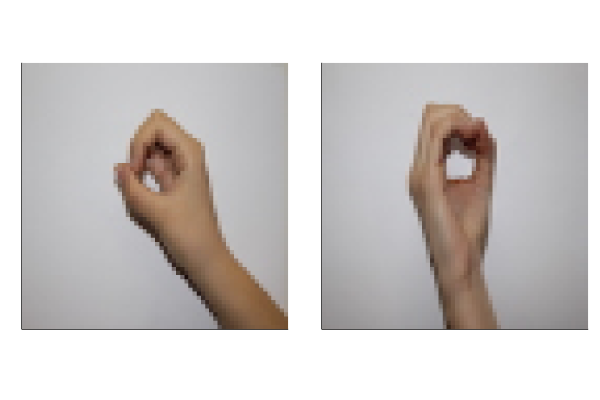

In [9]:
path = "/media/subhaditya/DATA/COSMO/Datasets/signLangNumbers/Dataset/subset/0"
ims = listImages(readdir(path),path, 64,true);

In [10]:
size(ims[1])

(3, 64, 64)

In [11]:
ar = [[1,3],[1,3]]
collect(Iterators.flatten(ar))

4-element Array{Int64,1}:
 1
 3
 1
 3

## ImageList

In [12]:
function ImageList(path,imageSize::Integer, singleFolder::Bool,disp::Bool)
    
    directory_files = readdir(path);
    no_files = size(directory_files)[1]
    folders = filter(x ->isdir(joinpath(path, x)), directory_files);
    function listExtender(lis, val)
        return [val for x in 1:length(lis)]
    end
    
    if singleFolder
        ims = listImages(directory_files,path,imageSize,true)
        le = length(ims)
        @info "1 class, $le images"
        return ims, listExtender(ims, directory_files[1])
        
    else
        if size(folders)[1]==0
            @info "No subfolders found"
        else
            @info "No of classes: $no_files"
            x, y = [],[]
            show_ims = []
            for (n, f) in enumerate(folders)
                @info f
                back = listImages(readdir(joinpath(path, f)), joinpath(path, f),imageSize,true)
                x = push!(x,back)
                y = push!(y, listExtender(back, f))
                
            end
            return collect(Iterators.flatten(x)), collect(Iterators.flatten(y))
        end
        
    end
end

ImageList (generic function with 1 method)

┌ Info: No of classes: 2
└ @ Main In[12]:20
┌ Info: 0
└ @ Main In[12]:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


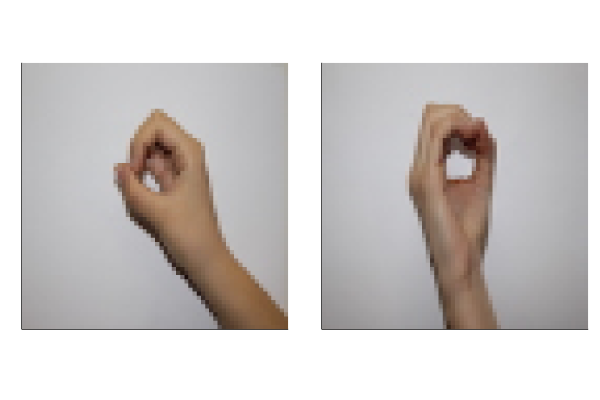

┌ Info: 1
└ @ Main In[12]:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


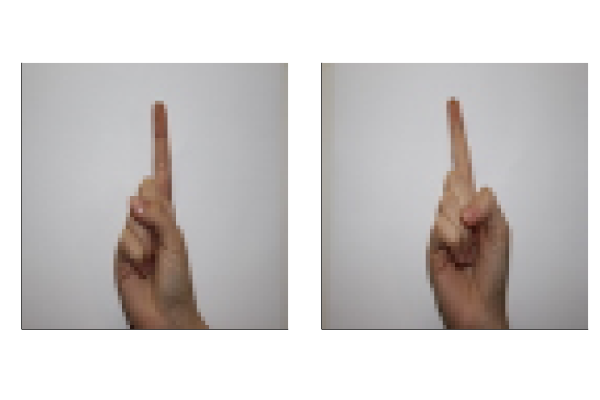

In [13]:
images = ImageList("/media/subhaditya/DATA/COSMO/Datasets/signLangNumbers/Dataset/subset",64,false,true);

## Split data

In [73]:
function flatter(arr)
    return collect(Iterators.flatten(arr))
end

flatter (generic function with 1 method)

In [109]:
function flatter2(arr)
    return collect(flatten(arr))
end

flatter2 (generic function with 1 method)

In [112]:
function splitter(images,split_pct)
    x_train,y_train,x_test,y_test = [],[],[],[]
    x,y = images[1],images[2]
    @show size(x),size(y)
    for i in unique(y)
        start, stop = findfirst(isequal(i),y),findlast(isequal(i),y)
#         @show start, stop
        size_d = stop-start
        size_spl = Integer(floor((1-split_pct)*size_d))
        push!(x_train, x[start: stop][1:size_spl])
        push!(y_train, y[start: stop][1:size_spl])
        push!(x_test, x[start: stop][size_spl:size_d])
        push!(y_test, y[start: stop][size_spl:size_d])
        
    end
    return flatter(x_train),flatter(y_train),flatter(x_test),flatter(y_test)
    
end

splitter (generic function with 1 method)

In [113]:
x_train,y_train,x_test,y_test = splitter(images,.25);
size(x_train),size(y_train),size(x_test),size(y_test)

(size(x), size(y)) = ((411,), (411,))


((306,), (306,), (105,), (105,))

In [118]:
a = x_train[1]

3×64×64 Array{Float64,3}:
[:, :, 1] =
 0.705882  0.709804  0.709804  0.709804  …  0.627451  0.619608  0.615686
 0.705882  0.709804  0.709804  0.709804     0.611765  0.603922  0.6
 0.705882  0.709804  0.709804  0.709804     0.615686  0.607843  0.596078

[:, :, 2] =
 0.717647  0.717647  0.717647  0.717647  …  0.631373  0.627451  0.619608
 0.717647  0.717647  0.717647  0.717647     0.615686  0.611765  0.603922
 0.717647  0.717647  0.717647  0.717647     0.619608  0.611765  0.6

[:, :, 3] =
 0.721569  0.721569  0.721569  0.721569  …  0.635294  0.631373  0.627451
 0.721569  0.721569  0.721569  0.721569     0.619608  0.615686  0.611765
 0.721569  0.721569  0.721569  0.721569     0.623529  0.619608  0.607843

...

[:, :, 62] =
 0.67451   0.694118  0.694118  0.698039  …  0.466667  0.462745  0.47451
 0.670588  0.694118  0.690196  0.690196     0.329412  0.321569  0.333333
 0.662745  0.690196  0.694118  0.705882     0.2       0.196078  0.211765

[:, :, 63] =
 0.666667  0.686275  0.690196  0.69019

In [ ]:
cat(a...,dims = 3)

In [ ]:
a

In [122]:
reshape(hcat(a...), (length(a[1]), length(a)))

1×12288 Array{Float64,2}:
 0.705882  0.705882  0.705882  0.709804  …  0.443137  0.305882  0.188235

In [81]:
function databunch(images,batchsize)
    xtrain,ytrain,xtest,ytest = splitter(images,0.25);
    @show unique(ytrain)
    @show size(xtrain)
    train_loader = DataLoader(xtrain, ytrain, batchsize=batchsize, shuffle=true)
    test_loader = DataLoader(xtest, ytest,  batchsize=batchsize)
    
    return train_loader, test_loader,length(unique(ytrain))
end

databunch (generic function with 1 method)

In [82]:
train_loader, test_loader,c = databunch(images, 64);

(size(x), size(y)) = ((411,), (411,))
unique(ytrain) = ["0", "1"]
size(xtrain) = (306,)


# Learner

In [55]:
function LeNet5(ims)
    imgsize = (ims, ims)
    
    out_conv_size = (imgsize[1]÷4 - 3, imgsize[2]÷4 - 3, 16)
    return Chain(x -> reshape(x, imageSize..., :),Conv((5, 5), imgsize[end]=>6, relu),
            MaxPool((2, 2)),
            Conv((5, 5), 6=>16, relu),
            MaxPool((2, 2)),
            x -> reshape(x, :, size(x, 4)),
            Dense(prod(out_conv_size), 120, relu), 
            Dense(120, 84, relu))
end

LeNet5 (generic function with 1 method)

## Model

In [56]:
function Mo(; imgsize=(64,64,3), nclasses=10) 
    out_conv_size = (imgsize[1]÷4 - 3, imgsize[2]÷4 - 3, 16)
    
    return Chain(
            x -> reshape(x, imgsize..., :),
            Conv((5, 5), imgsize[end]=>6, relu),
            MaxPool((2, 2)),
            Conv((5, 5), 6=>16, relu),
            MaxPool((2, 2)),
            x -> reshape(x, :, size(x, 4)),
            Dense(prod(out_conv_size), 120, relu), 
            Dense(120, 84, relu), 
            Dense(84, nclasses)
          )
end

Mo (generic function with 1 method)

In [57]:
Mo()

Chain(#17, Conv((5, 5), 3=>6, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((5, 5), 6=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), #18, Dense(2704, 120, relu), Dense(120, 84, relu), Dense(84, 10))

In [59]:
function setupArch(trainloader, num_classes, arch)
    imageSize = size(first(train_loader)[1])[1]
    @show imageSize
    last_sz = size(last(Chain(arch)[1]).W)[1]
    @show last_sz
#     @show size(last(Chain(arch)[1]).W)[1]
    
    arch = Chain(arch,Dense(last_sz,num_classes))
    return arch
end

setupArch (generic function with 1 method)

In [60]:
# Model = setupArch(train_loader,c,LeNet5(size(first(train_loader)[1])[1]))
# Model = setupArch(train_loader,c,LeNet5(3))
Model = Mo()

Chain(#17, Conv((5, 5), 3=>6, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((5, 5), 6=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), #18, Dense(2704, 120, relu), Dense(120, 84, relu), Dense(84, 10))

## Loss

In [61]:
loss(ŷ, y) = logitcrossentropy(ŷ, y)

loss (generic function with 1 method)

In [62]:
function eval_loss_accuracy(loader, model, device)
    l = 0f0
    acc = 0
    ntot = 0
    for (x, y) in loader
        x, y = x |> device, y |> device
        ŷ = model(x)
        l += loss(ŷ, y) * size(x)[end]        
        acc += sum(onecold(ŷ |> cpu) .== onecold(y |> cpu))
        ntot += size(x)[end]
    end
    return (loss = l/ntot |> round4, acc = acc/ntot*100 |> round4)
end

eval_loss_accuracy (generic function with 1 method)

# Train

In [63]:
function train(Model, train_loader, test_loader,epochs = 10,η=3e-4,λ=10e-4,savepath = "runs/",logtime =1, infotime = 10, checktime = 20)

    CuArrays.allowscalar(false)
    device = gpu
    @info "Training on GPU"
    num_params(model) = sum(length, Flux.params(model)) 
    round4(x) = round(x, digits=4)

    @info "$(train_loader.nobs) train and $(test_loader.nobs) valid examples"

    model = Model |> device
    @info "Model Info: $(num_params(model)) trainable params"    
    
    ps = Flux.params(model)  

    opt = ADAMW(η) 
    epoch_loss_train = zeros(0)
    epoch_loss_test = zeros(0)
    if λ > 0 
        opt = Optimiser(opt, WeightDecay(λ))
    end

  
    function report(epoch)
        train = eval_loss_accuracy(train_loader, model, device)
        test = eval_loss_accuracy(test_loader, model, device)        
        println("Epoch: $epoch   Train: $(train)   Test: $(test)")

        pl = plot(epoch_loss_train,label = "Train Loss")
        display(plot!(pl, epoch_loss_test,label = "Test Loss"))
        
    end
    
    @info "Starting Training"
    for epoch in 1:epochs
        p = ProgressMeter.Progress(epochs)

        for (x, y) in train_loader
            @show size(x), size(y)
            x, y = x |> device, y |> device
            gs = Flux.gradient(ps) do
                ŷ = model(x)
                loss(ŷ, y)
            end
            Flux.Optimise.update!(opt, ps, gs)
            
        end
        if epoch%logtime==0
            train = eval_loss_accuracy(train_loader, model, device)
            test = eval_loss_accuracy(test_loader, model, device)        
            push!(epoch_loss_train,convert(AbstractFloat, train.loss))

            push!(epoch_loss_test,convert(AbstractFloat, test.loss))
        end
        epoch % infotime == 0 && report(epoch)
        ProgressMeter.next!(p)
        if checktime > 0 && epoch % checktime == 0
            !ispath(savepath) && mkpath(savepath)
            modelpath = joinpath(savepath, "model.bson") 
            let model=cpu(model), args=struct2dict(args)
                BSON.@save modelpath model epoch args
            end
            @info "Model saved in \"$(modelpath)\""
        end
        
    end
end

train (generic function with 8 methods)

In [64]:
train(Model, train_loader, test_loader)

┌ Info: Training on GPU
└ @ Main In[63]:5
┌ Info: 306 train and 105 valid examples
└ @ Main In[63]:9


(size(x), size(y)) = ((64,), (64,))


┌ Info: Model Info: 338486 trainable params
└ @ Main In[63]:12
┌ Info: Starting Training
└ @ Main In[63]:34


DimensionMismatch: DimensionMismatch("array size 64 must be divisible by the product of the new dimensions (64, 64, 3, Colon())")

# Demo

In [ ]:
images = ImageList("/media/subhaditya/DATA/COSMO/Datasets/signLangNumbers/Dataset/subset/",64,false,false);

In [ ]:
train_loader, test_loader,c = databunch(images, 64);

In [ ]:
Model = setupArch(train_loader,c,LeNet5((imageSize,imageSize)))